In [8]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import contextily as ctx
from shapely.geometry import box
from scipy.spatial import cKDTree

In [9]:
#Extract the file containing all the data

file_path = 'raw_data-2.csv'

df = pd.read_csv(file_path)

print("The dataframe of all data hase the shape:",df.shape)
print("The parameters given by the data are:",df.columns.tolist())

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/2500993982.py:5: DtypeWarning: Columns (8,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


The dataframe of all data hase the shape: (340286, 31)
The parameters given by the data are: ['departure', 'arrival', 'route', 'departure_date_num', 'departure_time', 'seats_total', 'seats_booked', 'distance_BBC', 'announce_published_date', 'announce_views', 'arrival_latitude', 'arrival_longitude', 'car_mark', 'car_model', 'comment_average_note', 'commission', 'departure_date', 'departure_latitude', 'departure_longitude', 'departure_strike', 'driver_age', 'driving_quality', 'experience', 'member_since_month', 'member_since_year', 'price_driver', 'price_driver_default', 'price_driver_hcap', 'price_driver_lcap', 'published_ads', 'trip_description']


In [10]:
#Extracting the extrema coordinates for points departing from Paris

paris_df = df[df['departure'] == 'Paris']

In [11]:
def find_density_osmnx(paris_df, key, value):

    min_lat = paris_df['departure_latitude'].min()
    max_lat = paris_df['departure_latitude'].max()
    min_lon = paris_df['departure_longitude'].min()
    max_lon = paris_df['departure_longitude'].max()

    #bbox = box(2.275-0.01, 48.75-0.01, 2.375+0.01, 48.85+0.01)

    departure_gdf = gpd.GeoDataFrame(paris_df,
                                 geometry=gpd.points_from_xy(paris_df.departure_longitude, paris_df.departure_latitude),
                                 crs='EPSG:4326')

    #departure_gdf = departure_gdf[departure_gdf.geometry.within(bbox)]

    #bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

    tag  = {str(key): str(value)}
    all_stations = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tag)

    all_stations_points = all_stations[all_stations.geometry.geom_type == 'Point']

    if not all_stations_points.empty:
        all_stations_points['latitude'] = all_stations_points.geometry.y
        all_stations_points['longitude'] = all_stations_points.geometry.x
        all_stations_points['name'] = all_stations_points.name

    # Drop duplicates based on latitude and longitude
    all_stations_points = all_stations_points.drop_duplicates(subset=['latitude', 'longitude'])

    # Convert point_df latitudes and longitudes to a NumPy array (KDTree will be built from this)
    point_coords = np.array(list(zip(all_stations_points['latitude'],  all_stations_points['longitude'])))
    
    # Build the KDTree using point_df coordinates
    point_tree = cKDTree(point_coords)
    
    # Extract latitudes and longitudes from Paris_df for querying
    paris_coords = np.array(list(zip(paris_df['departure_latitude'], paris_df['departure_longitude'])))
    
    # Define the search radius in kilometers (1 km)
    search_radius = 1.0  # in kilometers
    
    # Convert 1 km to degrees (approximately). 1 km ≈ 0.009 degrees of latitude/longitude at the equator
    # This approximation will slightly vary with latitude, but it's fine for small distances
    search_radius_degrees = search_radius / 111  # 1 degree ≈ 111 km
    
    
    # Query the KDTree for all points within the search radius for each point in paris_df
    neighbors_indices = point_tree.query_ball_point(paris_coords, r=search_radius_degrees)
    
    # Count the number of neighbors for each point in paris_df
    neighbor_counts = [len(neighbors) for neighbors in neighbors_indices]

    fig, ax = plt.subplots(figsize=(10, 10))

    #bbox_gdf.boundary.plot(ax=ax, color='grey', linewidth=1, label='Bounding Box')
    
    for i in range(0,1):
        plt.plot(paris_coords[i,1],paris_coords[i,0],"xk", markersize=1)
        print(neighbor_counts[i])
        for j in range(len(neighbors_indices[i])):
            plt.plot(point_coords[neighbors_indices[i][j],1],point_coords[neighbors_indices[i][j],0],"og", markersize=1)
            # Add labels near each point
            plt.text(point_coords[neighbors_indices[i][j], 1], point_coords[neighbors_indices[i][j], 0], f"{all_stations_points['name'][neighbors_indices[i][j]]}", fontsize=8, color="blue")
            plt.plot([paris_coords[i,1], point_coords[neighbors_indices[i][j],1]],[paris_coords[i,0], point_coords[neighbors_indices[i][j],0]],"-r", linewidth = 1)
    
    ctx.add_basemap(ax, crs=departure_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)  
    plt.show()

    
    # Query the KDTree with the paris_df coordinates to find the nearest neighbors
    #_, indices = point_tree.query(paris_coords, k=1)
    
    # Get the coordinates of the nearest points
    #nearest_points = point_coords[indices]

    #id_points = [all_stations_points['name'][i] for i in indices]
    #id_lat = [all_stations_points['latitude'][i] for i in indices]
    #id_lon = [all_stations_points['longitude'][i] for i in indices]
    
    # Compute the geodesic distance for each pair of points
    #distances = [
      ##  geodesic((paris_lat, paris_lon), (nearest_lat, nearest_lon)).meters
       ## for (paris_lat, paris_lon), (nearest_lat, nearest_lon) in zip(paris_coords, nearest_points)
    #]
    
    # Return the indices of the nearest neighbors and the distances to those neighbors
    
    return neighbor_counts


In [12]:
def find_density_scratch(paris_df, list_lat, list_lon, list_name):

    min_lat = paris_df['departure_latitude'].min()
    max_lat = paris_df['departure_latitude'].max()
    min_lon = paris_df['departure_longitude'].min()
    max_lon = paris_df['departure_longitude'].max()

    #bbox = box(2.275-0.01, 48.75-0.01, 2.375+0.01, 48.85+0.01)

    departure_gdf = gpd.GeoDataFrame(paris_df,
                                 geometry=gpd.points_from_xy(paris_df.departure_longitude, paris_df.departure_latitude),
                                 crs='EPSG:4326')

    #departure_gdf = departure_gdf[departure_gdf.geometry.within(bbox)]

    #bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

    # Combine all three lists into tuples
    coords_with_names = list(zip(list_lat, list_lon, list_name))

    # Create a dictionary to ensure unique coordinates with one name
    unique_coords_with_names = {}
    for lat, lon, name in coords_with_names:
        if (lat, lon) not in unique_coords_with_names:
            unique_coords_with_names[(lat, lon)] = name

    # Separate the unique coordinates and names
    unique_latitudes, unique_longitudes = zip(*unique_coords_with_names.keys())
    unique_names = list(unique_coords_with_names.values())

    all_stations_points = pd.DataFrame()
    all_stations_points['latitude'] = unique_latitudes
    all_stations_points['longitude'] = unique_longitudes
    all_stations_points['name'] = unique_names
    print(all_stations_points)

    # Convert point_df latitudes and longitudes to a NumPy array (KDTree will be built from this)
    point_coords = np.array(list(zip(all_stations_points['latitude'],  all_stations_points['longitude'])))
    
    # Build the KDTree using point_df coordinates
    point_tree = cKDTree(point_coords)
    
    # Extract latitudes and longitudes from Paris_df for querying
    paris_coords = np.array(list(zip(paris_df['departure_latitude'], paris_df['departure_longitude'])))
    
    # Define the search radius in kilometers (1 km)
    search_radius = 1.0  # in kilometers
    
    # Convert 1 km to degrees (approximately). 1 km ≈ 0.009 degrees of latitude/longitude at the equator
    # This approximation will slightly vary with latitude, but it's fine for small distances
    search_radius_degrees = search_radius / 111  # 1 degree ≈ 111 km
    
    
    # Query the KDTree for all points within the search radius for each point in paris_df
    neighbors_indices = point_tree.query_ball_point(paris_coords, r=search_radius_degrees)
    
    # Count the number of neighbors for each point in paris_df
    neighbor_counts = [len(neighbors) for neighbors in neighbors_indices]

    fig, ax = plt.subplots(figsize=(10, 10))

    #bbox_gdf.boundary.plot(ax=ax, color='grey', linewidth=1, label='Bounding Box')
    
    for i in range(0,1):
        print(neighbor_counts[i])
        plt.plot(paris_coords[i,1],paris_coords[i,0],"xk", markersize=1)
        for j in range(len(neighbors_indices[i])):
            plt.plot(point_coords[neighbors_indices[i][j],1],point_coords[neighbors_indices[i][j],0],"og", markersize=1)
            # Add labels near each point
            plt.text(point_coords[neighbors_indices[i][j], 1], point_coords[neighbors_indices[i][j], 0], f"{all_stations_points['name'][neighbors_indices[i][j]]}", fontsize=8, color="blue")
            plt.plot([paris_coords[i,1], point_coords[neighbors_indices[i][j],1]],[paris_coords[i,0], point_coords[neighbors_indices[i][j],0]],"-r", linewidth = 1)
    
    ctx.add_basemap(ax, crs=departure_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)  
    plt.show()

    
    # Query the KDTree with the paris_df coordinates to find the nearest neighbors
    #_, indices = point_tree.query(paris_coords, k=1)
    
    # Get the coordinates of the nearest points
    #nearest_points = point_coords[indices]

    #id_points = [all_stations_points['name'][i] for i in indices]
    #id_lat = [all_stations_points['latitude'][i] for i in indices]
    #id_lon = [all_stations_points['longitude'][i] for i in indices]
    
    # Compute the geodesic distance for each pair of points
    #distances = [
      ##  geodesic((paris_lat, paris_lon), (nearest_lat, nearest_lon)).meters
       ## for (paris_lat, paris_lon), (nearest_lat, nearest_lon) in zip(paris_coords, nearest_points)
    #]
    
    # Return the indices of the nearest neighbors and the distances to those neighbors
    
    return neighbor_counts


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/2551617317.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  all_stations = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tags5)
/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:48: FutureWarning: T

['amenity', 'bicycle_parking', 'capacity', 'check_date', 'covered', 'geometry', 'supervised', 'access', 'survey:date', 'colour', 'fee', 'barrier', 'source', 'lit', 'level', 'description', 'operator', 'operator:type', 'website', 'name', 'capacity:cargo_bike', 'smoothness', 'surface', 'opening_hours', 'material', 'nodes', 'building', 'wall', 'charge', 'network', 'surveillance:type', 'layer', 'ref:IDFM', 'mapillary', 'fixme', 'surveillance', 'indoor', 'man_made', 'note', 'phone', 'ref', 'small_electric_vehicle', 'parking', 'lock', 'check_date:capacity', 'start_date', 'shelter', 'bicycle', 'motorcycle', 'wheelchair', 'payment:debit_cards', 'cargo_bike', 'contact:phone', 'contact:website', 'image', 'bike_ride', 'motor_vehicle', 'payment:credit_cards', 'parking_space', 'shelter_type', 'area', 'addr:housenumber', 'addr:street', 'owner', 'addr:postcode', 'is_in', 'natural', 'source:ref', 'public_transport', 'STIF:zone', 'bench', 'bin', 'bus', 'highway', 'ref:FR:STIF', 'ref:FR:STIF:stop_id', 'r

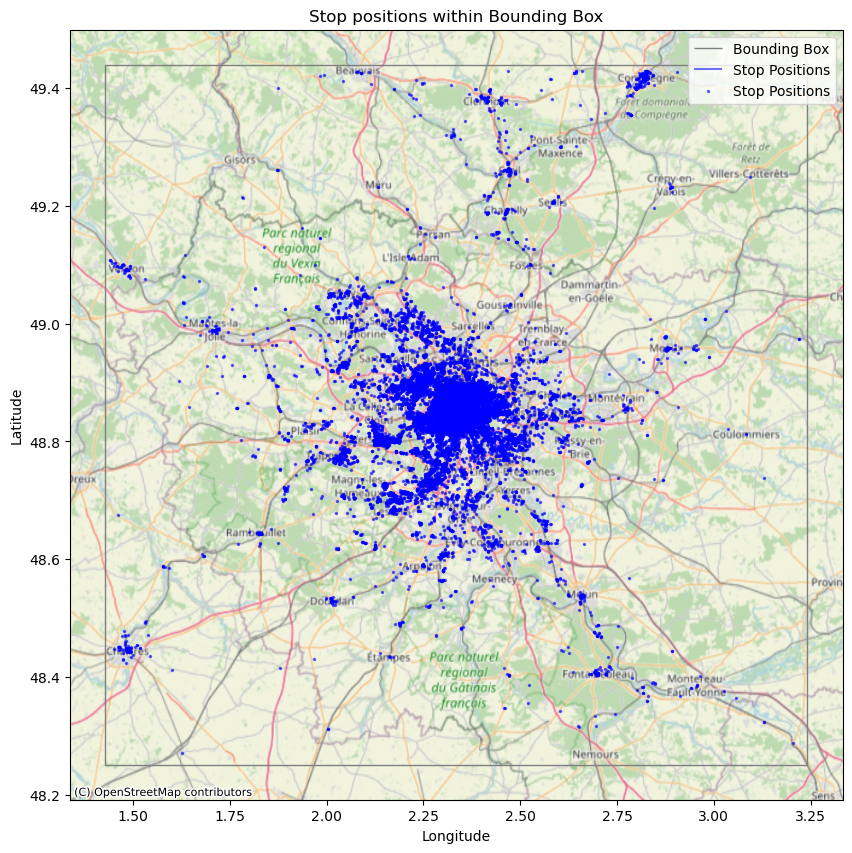

In [13]:
#Represent one of the feature : stops position
min_lat = paris_df['departure_latitude'].min()
max_lat = paris_df['departure_latitude'].max()
min_lon = paris_df['departure_longitude'].min()
max_lon = paris_df['departure_longitude'].max()

bbox = box(min_lon-0.01, min_lat-0.01, max_lon+0.01, max_lat+0.01)

departure_gdf = gpd.GeoDataFrame(paris_df,
                                 geometry=gpd.points_from_xy(paris_df.departure_longitude, paris_df.departure_latitude),
                                 crs='EPSG:4326')

departure_gdf = departure_gdf[departure_gdf.geometry.within(bbox)]

bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

tags5  = {'amenity': 'bicycle_parking'}
all_stations = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tags5)
print(all_stations.columns.tolist())

fig, ax = plt.subplots(figsize=(10, 10))

print(all_stations)

bbox_gdf.boundary.plot(ax=ax, color='grey', linewidth=1, label='Bounding Box')

if not all_stations.empty:
    all_stations.plot(ax=ax, color='blue', marker='o', markersize=2, label='Stop Positions', alpha=0.55)

ctx.add_basemap(ax, crs=departure_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Stop positions within Bounding Box")
plt.show()

In [14]:
from shapely.geometry import Point

# Configure OSMnx to use cache and console logging
ox.config(use_cache=True, log_console=True)

# Step 1: Get the boundary of Paris, France
city_name = "Paris, France"
paris_gdf = ox.geocode_to_gdf(city_name)
paris_gdf = paris_gdf.to_crs("EPSG:4326") 
paris_boundary = paris_gdf.unary_union  # Use as a polygon for filtering

# Step 2: Load your CSV data (inside Paris) and filter points within the Paris boundary
csv_file_path = "data_CSV/belib-points-de-recharge-pour-vehicules-electriques-donnees-statiques.csv"  # Update with your actual CSV path
csv_data = pd.read_csv(csv_file_path, sep=';')

# Split 'coordonneesXY' into 'longitude' and 'latitude'
csv_data[['latitude', 'longitude']] = csv_data['coordonneesXY'].str.split(',', expand=True).astype(float)
csv_data['name'] = csv_data['nom_station']

# Convert latitude and longitude into Point geometries
csv_data['geometry'] = csv_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
csv_gdf = gpd.GeoDataFrame(csv_data, geometry='geometry', crs='EPSG:4326')

# Filter points within the Paris boundary
csv_gdf = csv_gdf[csv_gdf.geometry.within(paris_boundary)]

# Step 3: Use OSMnx to get stations within a bounding box around Paris
# Define the bounding box (can use Paris coordinates or custom bounding box)
north, south, east, west = paris_boundary.bounds
tag = {'amenity': 'charging_station'}


# Query all stations in the bounding box
all_stations = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tag)
all_stations_points = all_stations[all_stations.geometry.geom_type == 'Point']

# Extract latitude and longitude
all_stations_points['latitude'] = all_stations_points.geometry.y
all_stations_points['longitude'] = all_stations_points.geometry.x
# Optionally extract name if it exists in the dataset
all_stations_points['name'] = ''
if 'name' in all_stations_points.columns:
    all_stations_points['name'] = all_stations_points['name']

# Filter to keep only points outside Paris
all_stations_outside_paris = all_stations_points[~all_stations_points.geometry.within(paris_boundary)]

# Step 4: Combine the points inside Paris from CSV and outside Paris from OSMnx
combined_points = pd.concat([csv_gdf[['name', 'latitude', 'longitude', 'geometry']], 
                             all_stations_outside_paris[['name', 'latitude', 'longitude', 'geometry']]])

# Step 5: Plot the combined points with the Paris boundary
#fig, ax = plt.subplots(figsize=(12, 12))
#combined_points.plot(ax=ax, color='blue', marker='o', label="Belib Points Paris", markersize=5)

#ctx.add_basemap(ax, crs=csv_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
# Add labels and show plot
#ax.set_title(f'Stations Inside and Outside Paris Boundary', fontsize=15)
#ax.legend()
#plt.show()
print(combined_points['latitude'].tolist())


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/1164246330.py:4: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/1164246330.py:34: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  all_stations = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tag)
/opt/anaconda3/lib/python3.9/s

[48.87063, 48.857124, 48.841206, 48.826504, 48.843754, 48.841286, 48.876163, 48.89061, 48.88472, 48.857094, 48.86409, 48.848423, 48.848423, 48.848423, 48.850033, 48.85262, 48.87026, 48.84116, 48.84116, 48.84737, 48.849297, 48.880447, 48.87559, 48.87559, 48.879482, 48.880642, 48.880642, 48.86536, 48.857796, 48.857258, 48.84948, 48.85988, 48.87237, 48.898304, 48.838547, 48.838547, 48.86986, 48.887253, 48.862465, 48.869926, 48.870422, 48.851254, 48.85807, 48.85245, 48.85245, 48.86821, 48.84837, 48.879597, 48.881493, 48.87359, 48.845577, 48.845577, 48.84071, 48.82958, 48.82958, 48.834854, 48.8861, 48.8861, 48.8432, 48.863, 48.8379, 48.8379, 48.8914, 48.8888, 48.8888, 48.8935, 48.8809, 48.8769, 48.843006, 48.8415, 48.85806, 48.85582, 48.86972, 48.85189, 48.849968, 48.833412, 48.837315, 48.832825, 48.83912, 48.82668, 48.83126, 48.83126, 48.84391, 48.835197, 48.861294, 48.87233, 48.873646, 48.87577, 48.86531, 48.84824, 48.878098, 48.854664, 48.832893, 48.824387, 48.828453, 48.83571, 48.841286

/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


electric
       latitude  longitude                               name
0     48.870630   2.333210  Paris | Boulevard des Capucines 7
1     48.857124   2.327753              Paris | Rue du Bac 35
2     48.841206   2.374883             Paris | Rue Villiot 10
3     48.826504   2.343366         Paris | Rue de Tolbiac 234
4     48.843754   2.320272      Paris | Avenue du Maine 16/18
...         ...        ...                                ...
2174  49.103903   1.448950                                   
2175  49.091589   1.487645                                   
2176  49.074995   1.530236                                   
2177  49.074916   1.530208                                   
2178  49.095801   1.466163                                   

[2179 rows x 3 columns]
11


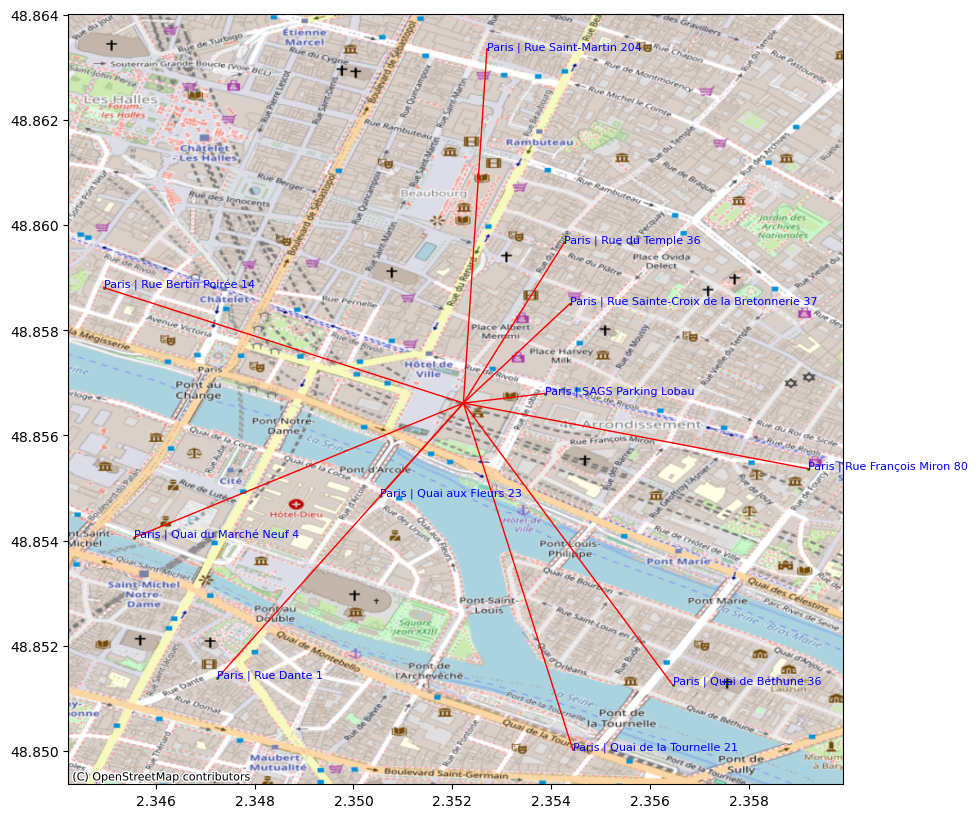

density length: 169283


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/78481618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_df['electric' + '_density'] = density


In [15]:
print('electric')
density = find_density_scratch(paris_df,combined_points['latitude'],combined_points['longitude'],combined_points['name'])
paris_df['electric' + '_density'] = density
print('density length:',len(density))

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/346803575.py:19: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  all_stations = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tag)
/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:48: FutureWarning: The 

111


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_1796/346803575.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(point_coords[neighbors_indices[i][j], 1], point_coords[neighbors_indices[i][j], 0], f"{all_stations_points['name'][neighbors_indices[i][j]]}", fontsize=8, color="blue")


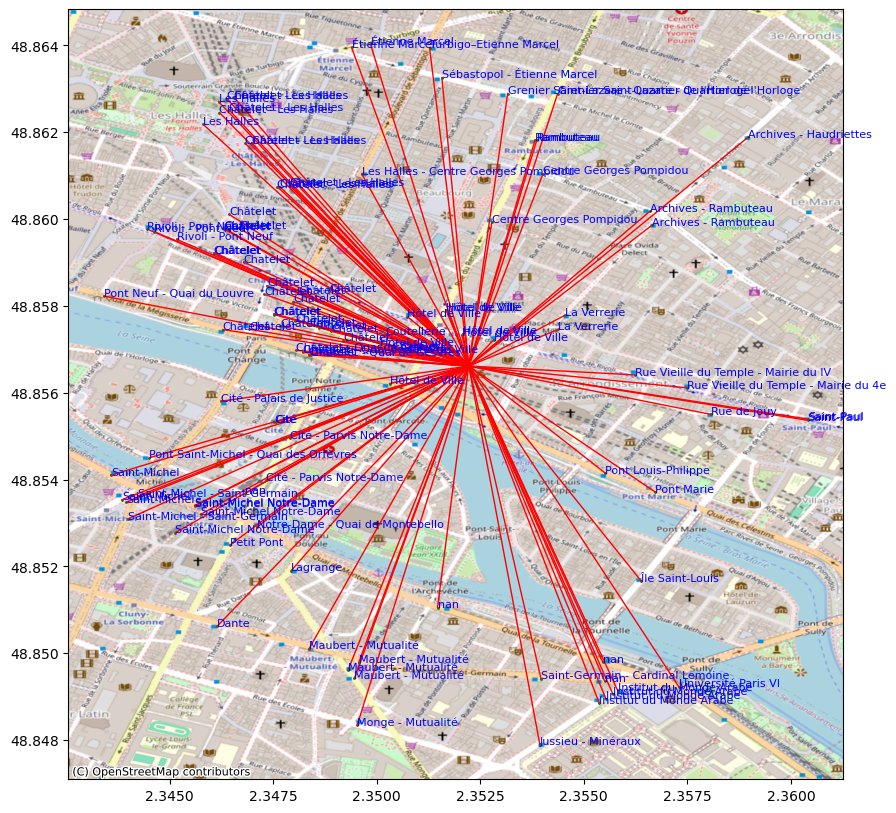

169283
[111, 66, 56, 56, 69, 56, 5, 67, 15, 60, 71, 23, 72, 34, 32, 148, 41, 56, 53, 29, 111, 78, 37, 74, 39, 111, 147, 44, 51, 65, 56, 70, 63, 43, 67, 54, 55, 53, 73, 90, 74, 72, 43, 112, 78, 42, 73, 45, 115, 31, 31, 57, 23, 30, 72, 37, 111, 148, 37, 31, 33, 26, 64, 44, 67, 111, 53, 74, 26, 90, 56, 20, 77, 90, 41, 38, 51, 65, 134, 53, 115, 36, 36, 71, 51, 19, 115, 31, 72, 48, 111, 35, 20, 22, 53, 35, 35, 53, 23, 115, 51, 111, 54, 73, 51, 14, 148, 55, 34, 68, 74, 64, 140, 51, 31, 44, 40, 111, 153, 62, 53, 70, 111, 22, 35, 26, 34, 90, 35, 111, 52, 41, 79, 115, 29, 24, 67, 52, 72, 57, 19, 111, 90, 99, 32, 35, 42, 73, 70, 58, 148, 115, 24, 150, 15, 57, 60, 111, 55, 49, 31, 58, 27, 53, 41, 38, 73, 40, 19, 36, 22, 35, 66, 72, 34, 15, 65, 69, 127, 111, 53, 53, 62, 29, 39, 37, 63, 111, 111, 47, 73, 25, 10, 90, 43, 55, 54, 49, 51, 111, 63, 111, 56, 84, 59, 26, 36, 115, 36, 23, 40, 56, 91, 27, 42, 115, 36, 53, 53, 31, 56, 38, 61, 35, 22, 49, 56, 22, 98, 65, 140, 33, 35, 26, 42, 53, 27, 106, 76,

In [16]:
densities = find_density_osmnx(paris_df, 'public_transport', 'stop_position')

print(len(densities))
print(densities)